# Competição DSA de Machine Learning - Edição Setembro/2019

## MARCIO DE LIMA

# Problema
Cada vez mais os robôs estão presentes em nosso dia a dia. Mas para que os robôs possam entender e navegar adequadamente por um local, eles precisam de informações sobre seu ambiente.

Nesta competição, você ajudará robôs (especificamente veículos autônomos terrestres) a reconhecer a superfície do piso em que estão, usando os dados coletados por sensores IMU (Inertial Measurement Units).

Os dados usados nesta competição foram coletados pelo Departamento de Processamento de Sinais da Tampere University na Finlândia. A coleta dos dados foi feita com um pequeno robô móvel equipado com sensores IMU sobre diferentes superfícies do piso nas instalações da universidade. A tarefa é prever em qual dos nove tipos de piso (carpete, ladrilhos, concreto, etc…) o robô está usando dados do sensor, como aceleração e velocidade. Tenha sucesso nesta competição e você ajudará a melhorar a navegação dos robôs autônomos em muitas superfícies diferentes.


** SE ESSE CODIGO FOR UTIL, VOTE , POR FAVOR **

# Carregando os dados

In [1]:
# Importando as bibliotecas
import os
path = os.getcwd()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier as xgb

import gc
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
# Importando os datasets
df_treino = pd.read_csv('data/X_treino.csv', low_memory=False)
df_treino_y = pd.read_csv('data/y_treino.csv', low_memory=False)


In [3]:
# Efetuando Merge dos dataSets de Treino - Chave: series_id

df = pd.merge(df_treino, df_treino_y, on='series_id', how='left')
df.shape

(487680, 15)

In [4]:
df.head(20)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.748570,2.103000,-9.7532,13,fine_concrete
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.339950,1.506400,-9.4128,13,fine_concrete
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.264290,1.592200,-8.7267,13,fine_concrete
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.426840,1.099300,-10.0960,13,fine_concrete
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.509690,1.468900,-10.4410,13,fine_concrete
5,0_5,0,5,-0.75853,-0.63439,-0.10483,-0.10580,0.059664,0.013043,-0.013231,-0.447450,0.992810,-10.4020,13,fine_concrete
6,0_6,0,6,-0.75853,-0.63441,-0.10481,-0.10569,0.082140,0.044356,-0.002696,-0.141630,0.734970,-9.4296,13,fine_concrete
7,0_7,0,7,-0.75852,-0.63444,-0.10480,-0.10561,0.056218,0.038162,-0.022931,-0.121600,0.075417,-8.6088,13,fine_concrete
8,0_8,0,8,-0.75851,-0.63445,-0.10485,-0.10559,-0.012846,0.039004,-0.007831,1.600000,0.816110,-7.6426,13,fine_concrete
9,0_9,0,9,-0.75851,-0.63443,-0.10489,-0.10567,-0.090082,0.027299,-0.009970,0.474960,0.909600,-8.8120,13,fine_concrete


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 487680 entries, 0 to 487679
Data columns (total 15 columns):
row_id                   487680 non-null object
series_id                487680 non-null int64
measurement_number       487680 non-null int64
orientation_X            487680 non-null float64
orientation_Y            487680 non-null float64
orientation_Z            487680 non-null float64
orientation_W            487680 non-null float64
angular_velocity_X       487680 non-null float64
angular_velocity_Y       487680 non-null float64
angular_velocity_Z       487680 non-null float64
linear_acceleration_X    487680 non-null float64
linear_acceleration_Y    487680 non-null float64
linear_acceleration_Z    487680 non-null float64
group_id                 487680 non-null int64
surface                  487680 non-null object
dtypes: float64(10), int64(3), object(2)
memory usage: 59.5+ MB


In [6]:
# Sumário estatístico
df.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886,37.601312
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341,20.980011
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000,0.000000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000,19.000000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300,39.000000
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792263,3.798800,-8.522700,55.000000
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000,72.000000


# Tratamento e Verificação dos Dados

In [7]:
#Verificando se existem dados null
df.isnull().values.any() 

False

In [8]:
#Checando valores NA nos dados
df.isna().any()[lambda x: x]

Series([], dtype: bool)

In [9]:
#Eliminando coluna sem utilidade
df = df.drop('row_id', axis=1)
df = df.drop('group_id', axis=1)

In [10]:
# Transformando a varíavel Target em Números com o LabelEncoder
labelencoder_surface = LabelEncoder()
df['surface_label'] = labelencoder_surface.fit_transform(df['surface'])

df.head(5)

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,surface,surface_label
0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,fine_concrete,2
1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,fine_concrete,2
2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,fine_concrete,2
3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,fine_concrete,2
4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,fine_concrete,2


# Explorando os dados

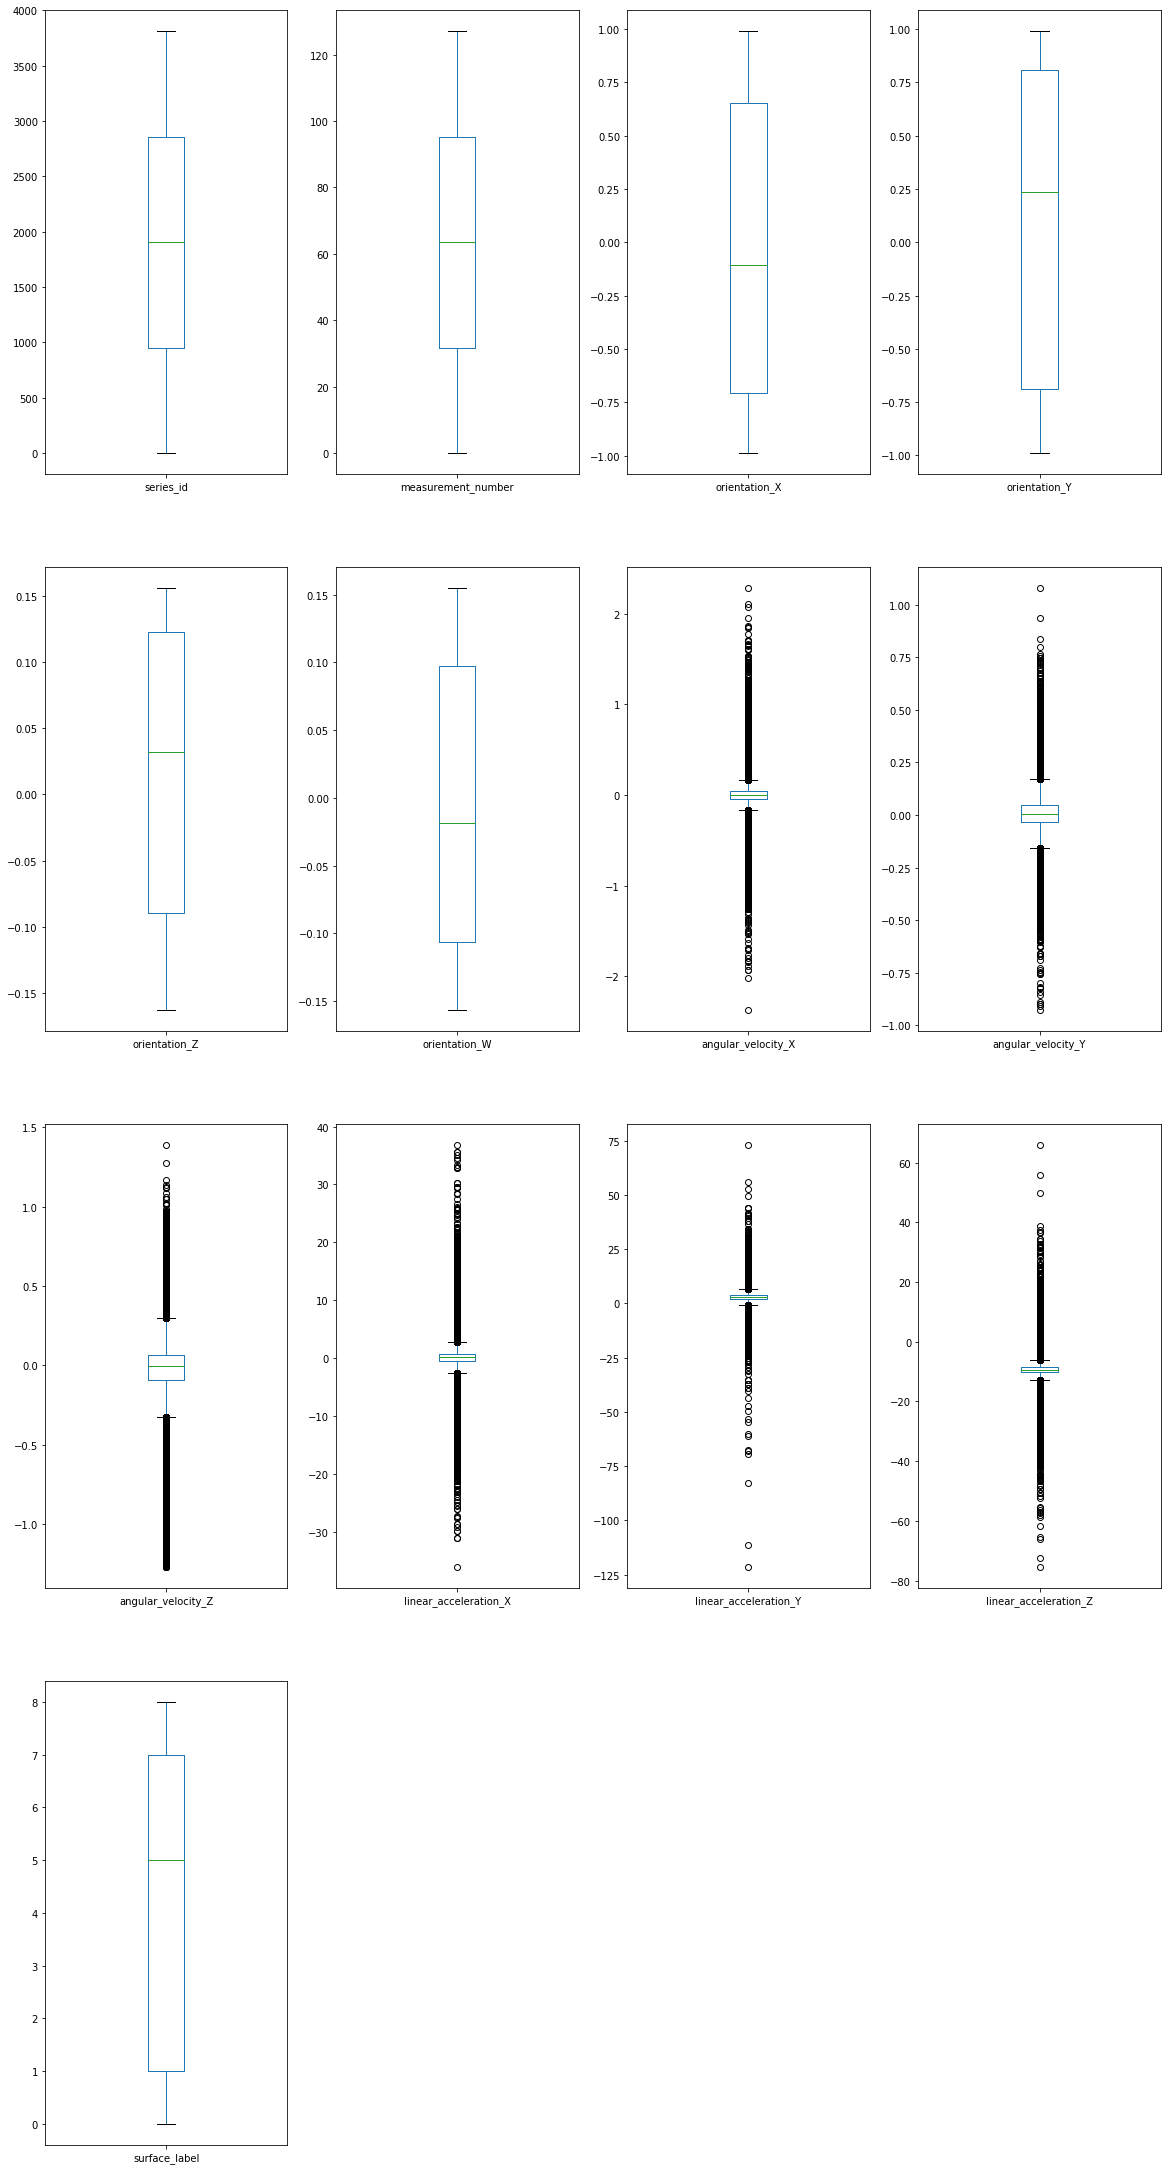

In [11]:
# Box-Plot
df.plot(kind = 'box', subplots = True, layout = (7,4), sharex = False, sharey = False, figsize=(20,70))
plt.show()

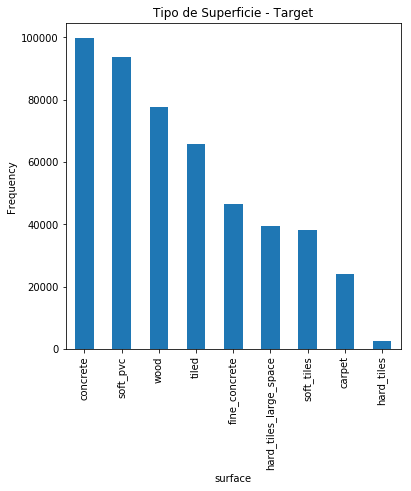

In [12]:
df['surface'].value_counts().plot(kind='bar', figsize=(6,6))
plt.title('Tipo de Superficie - Target')
plt.xlabel('surface')
plt.ylabel('Frequency')
plt.show()

In [13]:
# Verificando o skew de cada atributo
df.skew()

series_id                0.000000
measurement_number       0.000000
orientation_X            0.027906
orientation_Y           -0.180998
orientation_Z           -0.175208
orientation_W            0.039368
angular_velocity_X       0.052843
angular_velocity_Y       0.112263
angular_velocity_Z      -0.275458
linear_acceleration_X    0.111975
linear_acceleration_Y   -1.093905
linear_acceleration_Z   -0.065355
surface_label           -0.159903
dtype: float64

# Correlação entre as variáveis

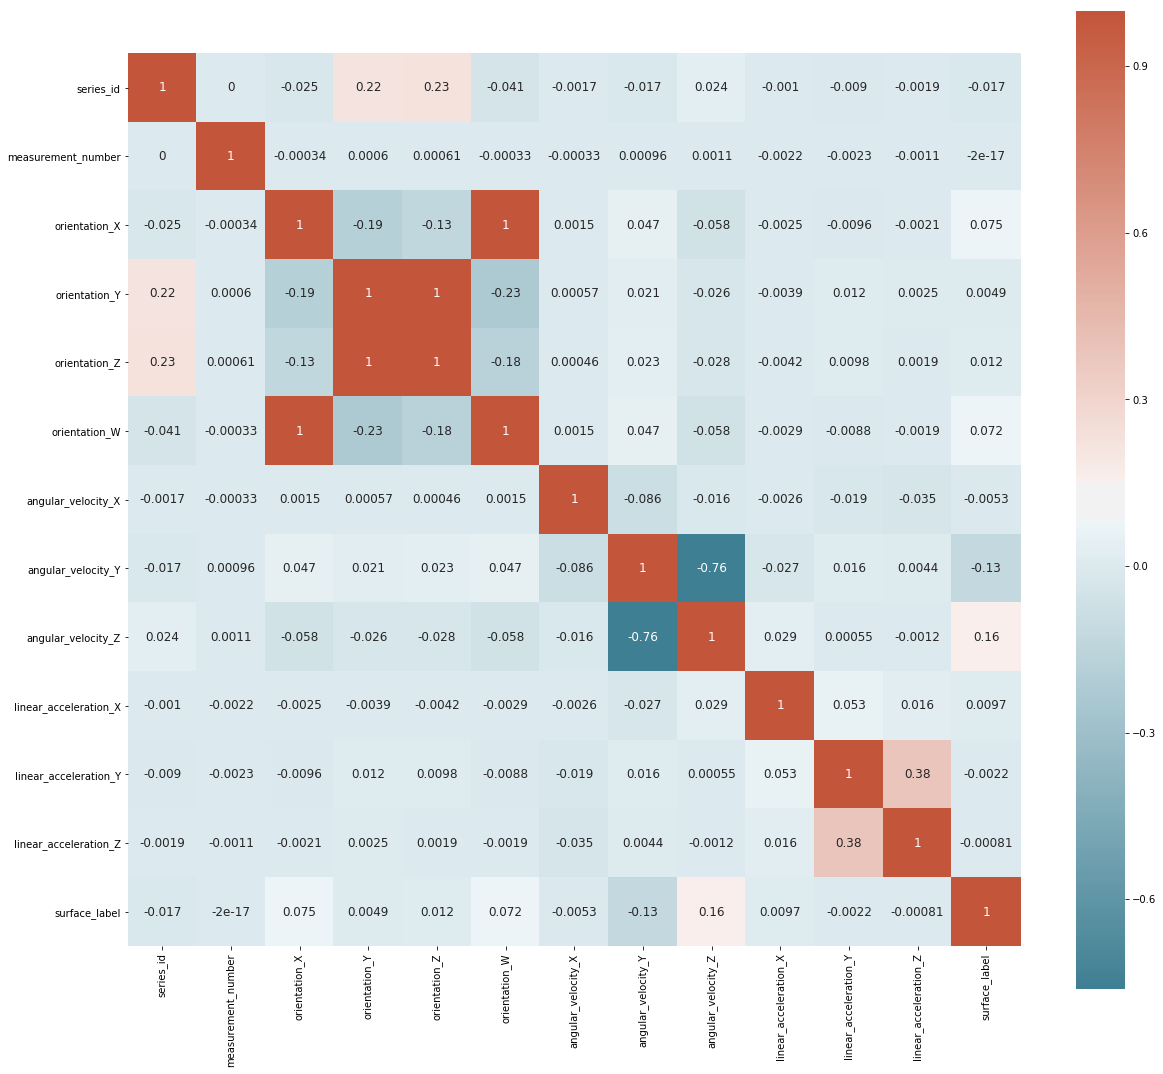

In [14]:
corr = df.corr()
_ , ax = plt.subplots( figsize =( 20 , 20 ) )
cmap = sns.diverging_palette( 220 , 20 , as_cmap = True )
_ = sns.heatmap(corr, cmap = cmap, square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, annot_kws = {'fontsize' : 12 })

In [15]:
# Correlação com a variavel TARGET
correlations_data = df[df.columns.drop('surface_label')].corrwith(df.surface_label).sort_values()
# Correlacao Negativa - Primeiros 5
print(correlations_data.head(5))
print('\n')
#Correlação Positiva - Ultimos 5
print(correlations_data.tail(5))


angular_velocity_Y      -0.126276
series_id               -0.017232
angular_velocity_X      -0.005343
linear_acceleration_Y   -0.002226
linear_acceleration_Z   -0.000807
dtype: float64


linear_acceleration_X    0.009695
orientation_Z            0.012337
orientation_W            0.072415
orientation_X            0.074993
angular_velocity_Z       0.158000
dtype: float64


In [16]:
# Limpando a memoria - Force
gc.collect()

52318

# Modelagem dos Dados

In [17]:
seed = 1313
df.surface.value_counts()

concrete                  99712
soft_pvc                  93696
wood                      77696
tiled                     65792
fine_concrete             46464
hard_tiles_large_space    39424
soft_tiles                38016
carpet                    24192
hard_tiles                 2688
Name: surface, dtype: int64

In [18]:
df.columns

Index(['series_id', 'measurement_number', 'orientation_X', 'orientation_Y',
       'orientation_Z', 'orientation_W', 'angular_velocity_X',
       'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X',
       'linear_acceleration_Y', 'linear_acceleration_Z', 'surface',
       'surface_label'],
      dtype='object')

In [19]:
# Montagem dos dados
array = df.values
X = array[:,0:12]
Y_texto = df.surface.values
Y = df.surface_label.values

In [20]:
X.shape , Y.shape

((487680, 12), (487680,))

In [21]:
# Igualando a escala dos dados
X = MinMaxScaler(feature_range = (0, 1)).fit_transform(X)

In [22]:
# Padronizando os dados
X = StandardScaler().fit_transform(X)

In [23]:
X

array([[-1.73159626, -1.71857161, -1.07989683, ..., -0.46928895,
        -0.36609528, -0.13647385],
       [-1.73159626, -1.69150749, -1.07989683, ...,  0.11262123,
        -0.64487185, -0.01683956],
       [-1.73159626, -1.66444337, -1.07989683, ..., -0.21039847,
        -0.60477961,  0.2242917 ],
       ...,
       [ 1.73159626,  1.66444337,  0.94350897, ...,  1.37684263,
         0.64284601,  0.42897738],
       [ 1.73159626,  1.69150749,  0.94368397, ...,  1.28927705,
         0.85349381, -0.02762914],
       [ 1.73159626,  1.71857161,  0.94385898, ...,  0.37134063,
         0.64887386, -0.39823535]])

# Dividindo os dados de Treino e Teste

In [24]:
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y, test_size=0.30, random_state=seed)

In [25]:
X_treino.shape, Y_treino.shape, X_teste.shape, Y_teste.shape

((341376, 12), (341376,), (146304, 12), (146304,))

# Feature selection com Random Forest

In [26]:
# Feature selection com Random Forest
from sklearn.ensemble import RandomForestClassifier 
from sklearn.feature_selection import SelectFromModel

clf = RandomForestClassifier(random_state=seed)
selector = clf.fit(X_treino, Y_treino)
fs = SelectFromModel(selector, prefit=True)

X_treino_new = fs.transform(X_treino)
X_teste_new = fs.transform(X_teste)

feature_idx = fs.get_support()
feature_idx = np.append(feature_idx, [False, False])
colunasSelecionadas = df.columns[feature_idx]

print(X_treino_new.shape, X_teste_new.shape)

(341376, 6) (146304, 6)


In [27]:
colunasSelecionadas

Index(['series_id', 'orientation_X', 'orientation_Y', 'orientation_Z',
       'orientation_W', 'angular_velocity_Z'],
      dtype='object')

In [28]:
df.columns

Index(['series_id', 'measurement_number', 'orientation_X', 'orientation_Y',
       'orientation_Z', 'orientation_W', 'angular_velocity_X',
       'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X',
       'linear_acceleration_Y', 'linear_acceleration_Z', 'surface',
       'surface_label'],
      dtype='object')

# Treinando vários modelos juntos - Modelos de Classificacao Basicos

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Definindo os valores para o número de folds
num_folds = 15

# Preparando a lista de modelos
modelos = []
modelos.append(('NB', GaussianNB()))
modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('CART', DecisionTreeClassifier()))

# Avaliando cada modelo em um loop
for nome, modelo in modelos:
    kfold = KFold(num_folds, True, random_state = seed)
    cv_results = cross_val_score(modelo, X, Y, cv = kfold, scoring = 'accuracy')
    msg = "%s: %f (%f)" % (nome, cv_results.mean() * 100, cv_results.std())
    print(msg)


NB: 37.957677 (0.002535)
KNN: 82.649688 (0.001646)
CART: 98.898048 (0.000692)


# Primeira Versao do Modelo com Features Selection

In [30]:
#Criando o Modelo - Versao 1
from xgboost import XGBClassifier
modelo = XGBClassifier(n_estimators=110, nthread=-1, seed=seed, objective='multi:softmax')

# Treinando o modelo
modelo.fit(X_treino_new, Y_treino, eval_metric="auc", verbose = False)

# Fazendo previsões
y_pred = modelo.predict(X_teste_new)
previsoes = [round(value) for value in y_pred]

#Resultado do Modelo - Versao 1
resultado = accuracy_score(Y_teste, previsoes)
print("Acuracia do Modelo 1: %.2f" % (resultado * 100.0))


Acuracia do Modelo 1: 79.53


# Segunda Versao do Modelo sem Features Selection

In [31]:
#Criando o Modelo - Versao 2
from xgboost import XGBClassifier
modelo2 = XGBClassifier(learning_rate=0.005, n_estimators=110, nthread=-1, seed=seed, objective='multi:softmax',num_class=9)

# Treinando o modelo
modelo2.fit(X_treino, Y_treino, eval_metric="auc", verbose = False)

# Fazendo previsões
y_pred2 = modelo2.predict(X_teste)
previsoes2 = [round(value) for value in y_pred2]

#Resultado do Modelo - Versao 1
resultado2 = accuracy_score(Y_teste, previsoes2)
print("Acuracia do Modelo 2: %.2f" % (resultado2 * 100.0))

Acuracia do Modelo 2: 61.15


# Algoritmos de Classificacao MultiVariada

In [33]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

clf = OneVsRestClassifier(XGBClassifier(n_estimators=150, objective='multi:softmax', num_class=9))
clf.fit(X_treino, Y_treino)


OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=150, n_jobs=1, nthread=None, num_class=9,
       objective='multi:softmax', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
          n_jobs=None)

In [34]:
y_pred3 = clf.predict(X_teste)
previsoes3 = [round(value) for value in y_pred3]

#Resultado do Modelo - Versao 1
resultado3 = accuracy_score(Y_teste, previsoes3)
print("Acuracia do Modelo 3: %.2f" % (resultado3 * 100.0))

from sklearn.metrics import classification_report
report = classification_report(Y_teste, previsoes3)

# Imprimindo o relatório
print(report)

Acuracia do Modelo 3: 81.21
              precision    recall  f1-score   support

           0       0.94      0.61      0.74      7251
           1       0.89      0.77      0.83     29902
           2       0.93      0.78      0.85     13993
           3       0.97      0.91      0.94       814
           4       0.94      0.77      0.85     11785
           5       0.95      0.79      0.86     28044
           6       0.93      0.89      0.91     11351
           7       0.95      0.84      0.89     19859
           8       0.52      0.93      0.67     23305

   micro avg       0.81      0.81      0.81    146304
   macro avg       0.89      0.81      0.84    146304
weighted avg       0.86      0.81      0.82    146304



## Escolhido o modelo de DecisionTreeClassifier - Melhor acurácia. 

# Modelo DecisionTreeClassifier otimizado com Features Selection

In [35]:
clf1 = OneVsRestClassifier(DecisionTreeClassifier(criterion='entropy',random_state=seed, splitter='best',min_samples_leaf=12,max_leaf_nodes=1000))

clf1.fit(X_treino_new, Y_treino)
y_pred4 = clf1.predict(X_teste_new)
previsoes4 = [round(value) for value in y_pred4]

#Resultado do Modelo - Versao 1
resultado4 = accuracy_score(Y_teste, previsoes4)
print("Acuracia do Modelo 4: %.2f" % (resultado4 * 100.0))

from sklearn.metrics import classification_report
report = classification_report(Y_teste, previsoes4)

# Imprimindo o relatório
print(report)


Acuracia do Modelo 4: 99.49
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7251
           1       1.00      0.99      0.99     29902
           2       1.00      1.00      1.00     13993
           3       1.00      0.99      1.00       814
           4       1.00      0.99      0.99     11785
           5       1.00      1.00      1.00     28044
           6       1.00      0.99      1.00     11351
           7       1.00      1.00      1.00     19859
           8       0.98      1.00      0.99     23305

   micro avg       0.99      0.99      0.99    146304
   macro avg       1.00      0.99      0.99    146304
weighted avg       0.99      0.99      0.99    146304



# Preparando os dados

In [36]:
# Dados de Teste - Limpeza e preparação dos dados para a predição

# Carregando o DataSet de Teste
df_final = pd.read_csv('data/X_teste.csv', low_memory=False)

# O modelo no DataSet de Teste para alguns seriesID, classifica surfaces diferentes 
# para o mesmo series_id cuja diferença são em algumas medições do sensor (temos 128 posições) 
# Testei várias soluções, mas optei por classificar a surface pela última análise do sensor = 127
# Exemplo de duplicação - series_id=6
df_final = df_final[df_final.measurement_number == 127]

#Eliminando as colunas sem utilidade
df_final = df_final.drop('row_id', axis=1)
#Features Selection
df_final = df_final.drop('measurement_number', axis=1)
df_final = df_final.drop('angular_velocity_X', axis=1)
df_final = df_final.drop('angular_velocity_Y', axis=1)
df_final = df_final.drop('linear_acceleration_X', axis=1)
df_final = df_final.drop('linear_acceleration_Y', axis=1)
df_final = df_final.drop('linear_acceleration_Z', axis=1)

#Padronizacao / Escala
X_predicao_final = df_final.values
X_predicao_final = MinMaxScaler(feature_range = (0, 1)).fit_transform(X_predicao_final)
X_predicao_final = StandardScaler().fit_transform(X_predicao_final)

# Fazendo as previsoes - Modelo 4 Otimizado
predicao_final = clf1.predict(X_predicao_final)
predicao_final_prob = clf1.predict_proba(X_predicao_final)

# Voltando a transformacao da variavel target em formato texto
predicao_final_texto = labelencoder_surface.inverse_transform(predicao_final)

In [37]:
predicao_final

array([7, 7, 8, ..., 4, 7, 5])

In [38]:
predicao_final_texto

array(['tiled', 'tiled', 'wood', ..., 'hard_tiles_large_space', 'tiled',
       'soft_pvc'], dtype=object)

In [39]:
predicao_final_prob

array([[0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.33333333, 0.        , 0.        , ..., 0.        , 0.33333333,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14285714, 0.        , 0.        , ..., 0.        , 0.85714286,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.42857143]])

In [40]:
df_final.shape, predicao_final_texto.shape, predicao_final_prob.shape

((3816, 6), (3816,), (3816, 9))

In [41]:
predicao_final_prob

array([[0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.33333333, 0.        , 0.        , ..., 0.        , 0.33333333,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14285714, 0.        , 0.        , ..., 0.        , 0.85714286,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.42857143]])

In [42]:
predicao_final_prob[:,0]

array([0.        , 0.33333333, 0.        , ..., 0.        , 0.14285714,
       0.        ])

# Montando DataFrame Final com as predições

In [43]:
#DataFrame do arquivo
df_submission = pd.DataFrame({
    "series_id": df_final.series_id, 
    "surface": predicao_final_texto
})

df_submission.head(50)

,series_id,surface
127,0,tiled
255,1,tiled
383,2,wood
511,3,wood
639,4,wood
767,5,wood
895,6,concrete
1023,7,soft_tiles
1151,8,fine_concrete
1279,9,wood


In [44]:
#Grava o arquivo
df_submission.to_csv('data/submission.csv', index=False)


# Obrigado